# Chapter 14: Regression Diagnostics and Structure

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats
from sklearn.linear_model import LinearRegression

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Diagnostics

In [2]:
np.random.seed(987654321)
x = np.random.uniform(1,100, size=500)
y = 250 + x + np.random.normal(loc=0, scale=10, size=500)
x = x.reshape(len(x), 1)
y = y.reshape(len(y), 1)
reg1 = LinearRegression().fit(x,y)
reg1.intercept_, reg1.coef_

(array([249.11972778]), array([[1.04228808]]))

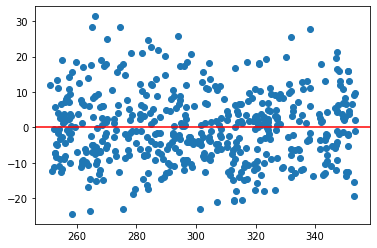

In [3]:
fitted_values = reg1.predict(x)
residuals = fitted_values - y

plt.scatter(fitted_values, residuals)
plt.axhline(0, color='red')
plt.show()